In [1]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
import random
import os
import shutil

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dataset=pd.read_csv('/content/gdrive/MyDrive/Facial map/training.csv')

In [4]:
dataset.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [6]:
dataset.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [7]:
def get_non_null(dataset):

    #this function removes the rows with null values

    dataset = dataset[np.sum(dataset.isna(), axis=1) == 0].reset_index()
    return dataset

In [8]:
def get_image_path(dataset):

    #this function adds new column with the image path and returns the dataset after adding

    dataset['image_path'] = [str(x) + '.jpg' for x in range(dataset.shape[0])]
    train_images_path = ('/content/gdrive/MyDrive/Facial map/images/train_images')
    dataset['image_path'] = (train_images_path + '/' + dataset['image_path'])
    return dataset

In [9]:
def get_classes_coord(dataset):

    #this function merges the point x coordinate with y of the dataset and returns the dataset after merge

    col_points_x = [dataset.columns[i] for i in range(1, len(dataset.columns)-1, 2)]
    col_points_y = [dataset.columns[i] for i in range(2, len(dataset.columns)-1, 2)]
    new_cols_names = [col_points_x[i].split('_x')[0] for i in range(len(col_points_x))]
    for x in range(len(new_cols_names)):
        dataset[new_cols_names[x]] = [[dataset[col_points_x[x]][i], dataset[col_points_y[x]][i]] for i in range(len(dataset))]
    return pd.concat([dataset[new_cols_names], dataset['image_path']], axis=1)

In [10]:
dataset_non_null   = get_non_null(dataset.copy())
# dataset_non_null.insert(1, 'class', 0)
# dataset_non_null.drop('index', axis = 1, inplace = True)
# dataset_non_null['class'] = np.uint8(dataset_non_null['class'])

dataset_with_paths = get_image_path(dataset_non_null.copy())
train_dataset      = get_classes_coord(dataset_with_paths)
train_dataset.head()

,left_eye_center,right_eye_center,left_eye_inner_corner,left_eye_outer_corner,right_eye_inner_corner,right_eye_outer_corner,left_eyebrow_inner_end,left_eyebrow_outer_end,right_eyebrow_inner_end,right_eyebrow_outer_end,nose_tip,mouth_left_corner,mouth_right_corner,mouth_center_top_lip,mouth_center_bottom_lip,image_path
0,"[66.0335639098, 39.0022736842]","[30.2270075188, 36.4216781955]","[59.582075188, 39.6474225564]","[73.1303458647, 39.9699969925]","[36.3565714286, 37.3894015038]","[23.4528721805, 37.3894015038]","[56.9532631579, 29.0336481203]","[80.2271278195, 32.2281383459]","[40.2276090226, 29.0023218045]","[16.3563789474, 29.6474706767]","[44.4205714286, 57.0668030075]","[61.1953082707, 79.9701654135]","[28.6144962406, 77.3889924812]","[43.3126015038, 72.9354586466]","[43.1307067669, 84.4857744361]",/content/gdrive/MyDrive/Facial map/images/trai...
1,"[64.3329361702, 34.9700765957]","[29.9492765957, 33.4487148936]","[58.8561702128, 35.2743489362]","[70.7227234043, 36.1871659574]","[36.0347234043, 34.3615319149]","[24.4725106383, 33.1444425532]","[53.9874042553, 28.2759489362]","[78.634212766, 30.4059234043]","[42.7288510638, 26.1460425532]","[16.8653617021, 27.0588595745]","[48.2062978723, 55.6609361702]","[56.4214468085, 76.352]","[35.1223829787, 76.0476595745]","[46.6845957447, 70.2665531915]","[45.4679148936, 85.4801702128]",/content/gdrive/MyDrive/Facial map/images/trai...
2,"[65.0570526316, 34.9096421053]","[30.9037894737, 34.9096421053]","[59.412, 36.3209684211]","[70.9844210526, 36.3209684211]","[37.6781052632, 36.3209684211]","[24.9764210526, 36.6032210526]","[55.7425263158, 27.5709473684]","[78.8873684211, 32.6516210526]","[42.1938947368, 28.1354526316]","[16.7911578947, 32.0871157895]","[47.5572631579, 53.5389473684]","[60.8229473684, 73.0143157895]","[33.7263157895, 72.732]","[47.2749473684, 70.1917894737]","[47.2749473684, 78.6593684211]",/content/gdrive/MyDrive/Facial map/images/trai...
3,"[65.2257391304, 37.261773913]","[32.0230956522, 37.261773913]","[60.0033391304, 39.1271791304]","[72.3147130435, 38.3809669565]","[37.6186434783, 38.7541147826]","[25.3072695652, 38.0079026087]","[56.4338086957, 30.9298643478]","[77.9102608696, 31.6657252174]","[41.6715130435, 31.0499895652]","[20.4580173913, 29.9093426087]","[51.8850782609, 54.1665391304]","[65.5988869565, 72.7037217391]","[37.2454956522, 74.1954782609]","[50.3031652174, 70.0916869565]","[51.5611826087, 78.2683826087]",/content/gdrive/MyDrive/Facial map/images/trai...
4,"[66.7253006135, 39.6212613497]","[32.244809816, 38.0420319018]","[58.5658895706, 39.6212613497]","[72.5159263804, 39.8844662577]","[36.9823803681, 39.0948515337]","[22.5061104294, 38.3052368098]","[57.2495705521, 30.6721766871]","[77.7629447853, 31.7372466258]","[38.0354355828, 30.9353815951]","[15.9258699387, 30.6721766871]","[43.2995337423, 64.8895214724]","[60.6714110429, 77.5232392638]","[31.1917546012, 76.9973006135]","[44.9627484663, 73.7073865031]","[44.2271411043, 86.8711656442]",/content/gdrive/MyDrive/Facial map/images/trai...


#plotting dataset

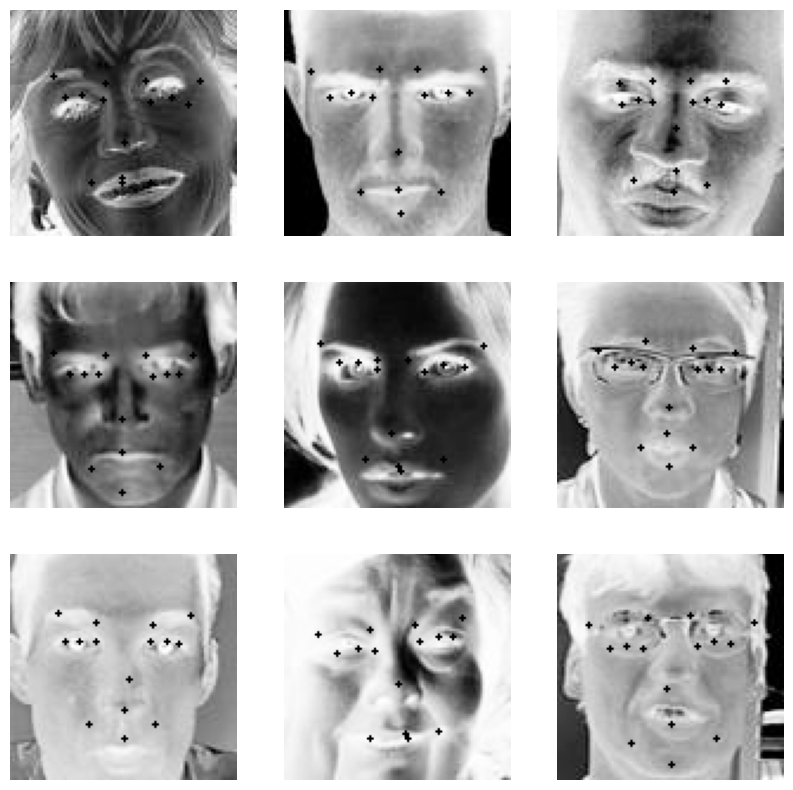

In [11]:
plt.figure(figsize = (10,10))
for plot_index in range(9):
    index  = random.randint(0, len(train_dataset) - 1)
    image  = io.imread(train_dataset['image_path'][index],1)
    points = train_dataset.loc[index][:-1]
    points = [np.uint(points[x]) for x in range(len(points))]
    for point_index in range(len(points)):
        image = cv2.circle(image, points[point_index] , radius=1, color=1, thickness=-1)
    plt.subplot(3,3, plot_index + 1)
    plt.imshow(image, cmap='Greys')
    plt.axis('off')

In [12]:
train_dataset.columns

Index(['left_eye_center', 'right_eye_center', 'left_eye_inner_corner',
       'left_eye_outer_corner', 'right_eye_inner_corner',
       'right_eye_outer_corner', 'left_eyebrow_inner_end',
       'left_eyebrow_outer_end', 'right_eyebrow_inner_end',
       'right_eyebrow_outer_end', 'nose_tip', 'mouth_left_corner',
       'mouth_right_corner', 'mouth_center_top_lip', 'mouth_center_bottom_lip',
       'image_path'],
      dtype='object')

In [13]:
os.mkdir('data')
os.mkdir('data/images')
os.mkdir('data/labels')
os.mkdir('data/images/train')
os.mkdir('data/images/val')
os.mkdir('data/labels/train')
os.mkdir('data/labels/val')

In [55]:
# split into train and val
for index in range(len(train_dataset) - 200):
    file_name = os.path.split(train_dataset.loc[index]['image_path'])[1].split('.')[0]
    inst_data = [0, 0.5,0.5,0.5,0.5]
    label_path = os.path.join('/content/data/labels/train', (file_name + '.txt'))
    image_path = os.path.join('/content/data/images/train', (file_name + '.jpg'))
    slc = train_dataset.iloc[index].to_numpy(copy=True)[:-1]
    for i in range(15):
        inst_data.extend([slc[i][0]/96, slc[i][1]/96])
    np.array(inst_data,dtype = object).tofile(f'{label_path}', sep=' ')
    shutil.copyfile(train_dataset.loc[index]['image_path'], image_path)

In [56]:
for index in range((len(train_dataset) - 200), len(train_dataset)):
    file_name = os.path.split(train_dataset.loc[index]['image_path'])[1].split('.')[0]
    inst_data = [0, 0.5,0.5,0.5,0.5]
    label_path = os.path.join('/content/data/labels/val', (file_name + '.txt'))
    image_path = os.path.join('/content/data/images/val', (file_name + '.jpg'))
    slc = train_dataset.iloc[index].to_numpy(copy=True)[:-1]
    for i in range(15):
        inst_data.extend([slc[i][0]/96, slc[i][1]/96])
    np.array(inst_data,dtype = object).tofile(f'{label_path}', sep=' ')
    shutil.copyfile(train_dataset.loc[index]['image_path'], image_path)

In [57]:
!pip install ultralytics

In [67]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n-pose.pt')  # load an official model



In [68]:
# Predict with the model
results = model('/content/gdrive/MyDrive/Facial map/images/test_images/1.jpg')  # predict on an image


image 1/1 /content/gdrive/MyDrive/Facial map/images/test_images/1.jpg: 640x640 1 person, 8.7ms
Speed: 25.0ms preprocess, 8.7ms inference, 77.6ms postprocess per image at shape (1, 3, 640, 640)


In [72]:

results = model.train(data='data.yaml', epochs=10, imgsz=640)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, 

train: Scanning /content/data/labels/train.cache... 1940 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1940/1940 [00:00<?, ?it/s]

albumentations: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'



val: Scanning /content/data/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train15
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.93G     0.4266      2.277          0     0.2913      1.004          4        640: 100%|██████████| 122/122 [00:44<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200        200          1      0.995      0.995      0.971      0.749      0.735      0.613      0.171



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.66G      0.361      2.311          0     0.2597     0.9466          4        640: 100%|██████████| 122/122 [00:38<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200        200      0.994       0.99      0.995      0.967      0.668      0.665      0.537      0.139



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.67G     0.3193      2.369          0     0.2415     0.8949          4        640: 100%|██████████| 122/122 [00:35<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        200        200          1      0.994      0.995      0.982      0.636       0.63      0.525      0.154



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.66G     0.2947       2.21          0     0.2256     0.8778          4        640: 100%|██████████| 122/122 [00:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200        200      0.994      0.995      0.995      0.962      0.754      0.745      0.644      0.178



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.67G     0.2796      2.189          0     0.2149     0.8684          4        640: 100%|██████████| 122/122 [00:36<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200        200          1          1      0.995      0.991      0.673       0.67      0.574      0.157



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.66G     0.2446      2.141          0     0.1965     0.8439          4        640: 100%|██████████| 122/122 [00:42<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        200        200          1          1      0.995      0.994      0.776       0.77      0.715      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.67G     0.2469      2.124          0     0.1923     0.8485          4        640: 100%|██████████| 122/122 [00:42<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200        200      0.999          1      0.995      0.992      0.762      0.755       0.68       0.22



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.66G     0.1968      2.072          0     0.1648     0.8242          4        640: 100%|██████████| 122/122 [00:37<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200        200          1          1      0.995      0.994      0.747       0.74      0.687      0.216



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.67G     0.1808      2.018          0     0.1525     0.8099          4        640: 100%|██████████| 122/122 [00:38<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200        200          1          1      0.995      0.993      0.792      0.785      0.724      0.231



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.66G     0.1743      2.033          0      0.144     0.8146          4        640: 100%|██████████| 122/122 [00:38<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200        200          1          1      0.995      0.995      0.782      0.775      0.735      0.245



10 epochs completed in 0.121 hours.
Optimizer stripped from runs/pose/train15/weights/last.pt, 6.6MB
Optimizer stripped from runs/pose/train15/weights/best.pt, 6.6MB

Validating runs/pose/train15/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3154073 parameters, 0 gradients, 8.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


                   all        200        200          1          1      0.995      0.995      0.782      0.775      0.735      0.243
WARNING ⚠️ ConfusionMatrix plot failure: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'
WARNING ⚠️ ConfusionMatrix plot failure: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'
Speed: 0.7ms preprocess, 3.3ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/pose/train15


In [98]:
import os
import random
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Set the model path
model_path = '/content/runs/pose/train15/weights/best.pt'

# Path to the directory containing validation images
val_images_dir = '/content/data/images/val'
images = os.listdir(val_images_dir)

# Set up the figure
plt.figure(figsize=(20, 20))

# Loop over 9 random images
for plot_index in range(9):
    # Randomly select an index
    index = random.randint(0, len(images) - 1)

    # Construct the full path to the image
    image_path = os.path.join(val_images_dir, images[index])

    # Read the image using cv2
    img = cv2.imread(image_path)

    # Load the YOLO model
    model = YOLO(model_path)

    # Perform pose estimation
    results = model(image_path)[0]

    # Annotate keypoints on the image
    for result in results:
        print("Keypoints:", result.keypoints)
        for keypoint_indx, keypoint in enumerate(result.keypoints.data.tolist()[0]):
            print(f"Keypoint {keypoint_indx}: {keypoint}")
            cv2.putText(img, str(keypoint_indx), (int(keypoint[0]), int(keypoint[1])),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.1, (0, 255, 0), 1)

    # Display the annotated image
    plt.subplot(3, 3, plot_index + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()



image 1/1 /content/data/images/val/2106.jpg: 640x640 1 face, 26.7ms
Speed: 2.6ms preprocess, 26.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Keypoints: ultralytics.engine.results.Keypoints object with attributes:

conf: None
data: tensor([[[66.9006, 37.8159],
         [28.9381, 38.0010],
         [59.5879, 38.8791],
         [74.4146, 38.9587],
         [35.9016, 39.0846],
         [21.1286, 39.0772],
         [56.6021, 29.8432],
         [81.1671, 30.8228],
         [39.0567, 30.1156],
         [14.5844, 31.1099],
         [47.7300, 59.3084],
         [63.5633, 78.0881],
         [31.9910, 78.2093],
         [47.5812, 74.2583],
         [47.6267, 84.4718]]], device='cuda:0')
has_visible: False
orig_shape: (96, 96)
shape: torch.Size([1, 15, 2])
xy: tensor([[[66.9006, 37.8159],
         [28.9381, 38.0010],
         [59.5879, 38.8791],
         [74.4146, 38.9587],
         [35.9016, 39.0846],
         [21.1286, 39.0772],
         [56.6021, 29.8432],
         [81.

In [97]:
import os
import random
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Set the model path
model_path = '/content/runs/pose/train15/weights/best.pt'

# Path to the directory containing validation images
val_images_dir = '/content/data/images/val'
images = os.listdir(val_images_dir)

# Set up the figure
plt.figure(figsize=(20, 20))

# Loop over 9 random images
for plot_index in range(9):
    # Randomly select an index
    index = random.randint(0, len(images) - 1)

    # Construct the full path to the image
    image_path = os.path.join(val_images_dir, images[index])

    # Read the image using cv2
    img = cv2.imread(image_path)

    # Load the YOLO model
    model = YOLO(model_path)

    # Perform pose estimation
    results = model(image_path)[0]

    # Annotate keypoints on the image
    for result in results:
        for keypoint_indx, keypoint in enumerate(result.keypoints.data.tolist()[0]):
            cv2.putText(img, str(keypoint_indx), (int(keypoint[0]), int(keypoint[1])),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.1, (0, 255, 0), 1)

    # Display the annotated image
    plt.subplot(3, 3, plot_index + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


image 1/1 /content/data/images/val/2018.jpg: 640x640 1 face, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/images/val/1996.jpg: 640x640 1 face, 18.9ms
Speed: 2.6ms preprocess, 18.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/images/val/1964.jpg: 640x640 1 face, 17.5ms
Speed: 2.5ms preprocess, 17.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/images/val/2093.jpg: 640x640 1 face, 29.5ms
Speed: 2.5ms preprocess, 29.5ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/images/val/1958.jpg: 640x640 1 face, 17.6ms
Speed: 2.6ms preprocess, 17.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/images/val/2109.jpg: 640x640 1 face, 17.9ms
Speed: 2.7ms preprocess, 17.9ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

im